# Task 3: Comparing Trajectory Paths

In [1]:
# dependencies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List

In [2]:
dataset = pd.read_csv('data/geolife-cars.csv')

## Task Function Setup

In [3]:
#Function: computes distance
def dist(a, b):
    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

In [4]:
def dtw(seriesA, seriesB):
    m, n = len(seriesA) + 1, len(seriesB) + 1
    dp = [[[float('inf'), set()] for _ in range(n)] for _ in range(m)]
    dp[0][0] = [0, None]

    for i in range(m - 1):
        for j in range(n - 1):
            curr = dp[i][j]
            curr[0] += dist(seriesA[i], seriesB[j]) ** 2
            if curr[0] < dp[i + 1][j][0]: dp[i + 1][j] = [curr[0], (i, j)]
            if curr[0] < dp[i][j + 1][0]: dp[i][j + 1] = [curr[0], (i, j)]
            if curr[0] < dp[i + 1][j + 1][0]: dp[i + 1][j + 1] = [curr[0], (i, j)]
    
    total_cost, last = dp[len(seriesA) - 1][len(seriesB) - 1]
    
    path = {(len(seriesA) - 1, len(seriesB) - 1)}
    while last is not None:
        path.add(last)
        last = dp[last[0]][last[1]][1]

    return total_cost / len(path), path

In [5]:
def fd(seriesA, seriesB):
    m, n = len(seriesA) + 1, len(seriesB) + 1
    dp = [[[float('inf'), set()] for _ in range(n)] for _ in range(m)]
    dp[0][0] = [0, None]

    for i in range(m - 1):
        for j in range(n - 1):
            curr = dp[i][j]
            curr[0] = max(curr[0], dist(seriesA[i], seriesB[j]))
            if curr[0] < dp[i + 1][j][0]: dp[i + 1][j] = [curr[0], (i, j)]
            if curr[0] < dp[i][j + 1][0]: dp[i][j + 1] = [curr[0], (i, j)]
            if curr[0] < dp[i + 1][j + 1][0]: dp[i + 1][j + 1] = [curr[0], (i, j)]
    
    total_cost, last = dp[len(seriesA) - 1][len(seriesB) - 1]
    
    path = {(len(seriesA) - 1, len(seriesB) - 1)}
    while last is not None:
        path.add(last)
        last = dp[last[0]][last[1]][1]
    
    return total_cost, path

## 5.2.2-3: Plotting histograms of Eavg and Emax

In [6]:
#Histograms for 3 trajectory pairs
pairs = [
    ('128-20080503104400', '128-20080509135846'),
    ('010-20081016113953', '010-20080923124453'),
    ('115-20080520225850', '115-20080615225707')
]

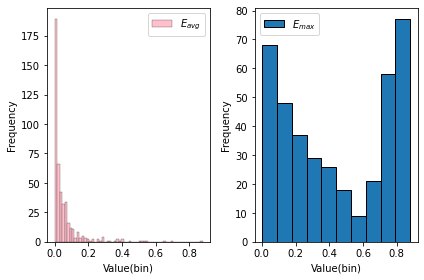

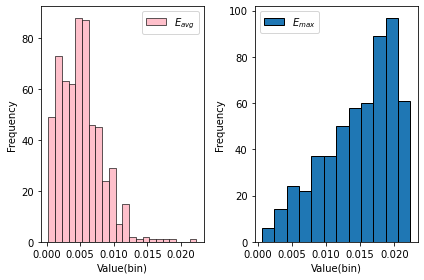

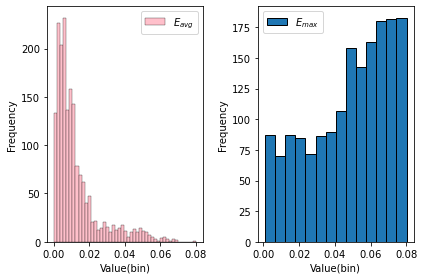

In [7]:
#Plotting 3 trajectory pairs 
for a, b in pairs:
    seriesA = list(dataset[dataset.id_ == a][['x', 'y']].itertuples(index=False, name=None))
    seriesB = list(dataset[dataset.id_ == b][['x', 'y']].itertuples(index=False, name=None))
    
    cost_avg, e_avg = dtw(seriesA, seriesB)
    cost_max, e_max = fd(seriesA, seriesB)
    
    dist_avg = [dist(seriesA[ai], seriesB[bi]) for ai, bi in e_avg]
    dist_max = [dist(seriesA[ai], seriesB[bi]) for ai, bi in e_max]
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.histplot(dist_avg, alpha=1, color = 'pink', label='$E_{avg}$', ax = ax[0])
    sns.histplot(dist_max, alpha=1, label='$E_{max}$', ax = ax[1])
    #print(dist_avg)
    #print(dist_max)

    ax[0].legend(['$E_{avg}$'])
    ax[1].legend(['$E_{max}$'])
    ax[0].set_xlabel('Value(bin)')
    ax[0].set_ylabel('Frequency')
    ax[1].set_xlabel('Value(bin)')
    ax[1].set_ylabel('Frequency')
    plt.tight_layout()
    
    plt.show()

In [8]:
#Import functions to calculate ε-simplications from Task 2

def TS_greedy(T: List[Tuple[float, float]], eps: float) -> List[Tuple[float, float]]:
    if len(T) < 3:
        # Base case, the trajectory cannot be simplified further
        return T
    else:
        # Initialize the simplified trajectory, T_star, with the first and last points of the trajectory
        T_star = [T[0], T[-1]]
        # Find the point with max distance
        dmax = 0
        index = 0
        for i in range(1, len(T) - 1):
            dis = d(T[i], T_star)
            if dis > dmax:
                index = i 
                dmax = dis
        # Check if the epsilon criterion is met
        if dmax <= eps: 
            # T_star is sufficient to represent the current trajectory within max error epsilon
            return T_star 
        else:
            # Max distance > epsilon
            # Recurse on left and right, seperated by the point with max distance;
            return TS_greedy(T[0:index], eps) + TS_greedy(T[index:], eps) 
        
def d(q: Tuple[float, float], e: List[Tuple[float, float]]) -> float:
    # Let the start point of e be a, and end point be b 
    a, b = e
    # Compute the dot product of vectors aq and ab
    dot_product = (q[0] - a[0]) * (b[0] - a[0]) + (q[1] - a[1]) * (b[1] - a[1])
    # Compute the length of ab (squared)
    ab_length_sq = (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2
    # Compute the projection of vector aq onto vector ab
    projection = dot_product / ab_length_sq
    if projection <= 0:
        # Point q is closest to the start point (a) of line segment e
        return ((q[0] - a[0]) ** 2 + (q[1] - a[1]) ** 2) ** 0.5
    elif projection >= 1:
        # Point q is closest to the end point (b) of line segment e 
        return ((q[0] - b[0]) ** 2 + (q[1] - b[1]) ** 2) ** 0.5
    else:
        # Point q is closest to the point on line segment e between its start (a) and end (b) points
        closest_x = a[0] + projection * (b[0] - a[0])
        closest_y = a[1] + projection * (b[1] - a[1])
        return ((q[0] - closest_x) ** 2 + (q[1] - closest_y) ** 2) ** 0.5

In [9]:
#Histograms for Simplifications

#Import T1 and T2
df = dataset
trajec1 = df[df["id_" ] == "115-20080520225850"]
tA = list(zip(trajec1.x, trajec1.y))

trajec2 = df[df["id_" ] == "115-20080615225707"]
tB = list(zip(trajec2.x, trajec2.y))

#Compute epsilon-simplifications
A003 = TS_greedy(tA, 0.03)
B003 = TS_greedy(tB, 0.03)
A01 = TS_greedy(tA, 0.1)
B01 = TS_greedy(tB, 0.1)
A03 = TS_greedy(tA, 0.3)
B03 = TS_greedy(tB, 0.3)

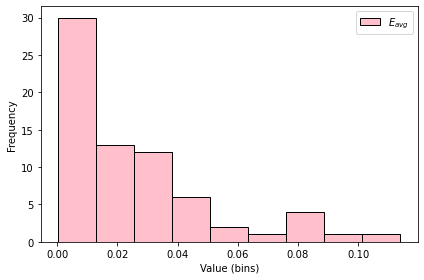

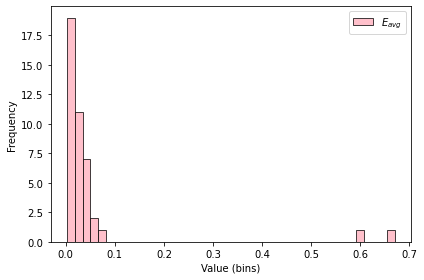

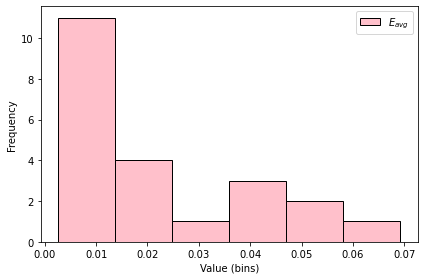

In [10]:
#Format Data
pairs1 = [
    (A003, B003),
    (A01, B01),
    (A03, B03)
]

#Plotting histograms for simplifications with ε = 0.03, 0.1, 0.3

for a, b in pairs1:
    cost_avg, e_avg = dtw(a, b)
    cost_max, e_max = fd(a, b)
    
    dist_avg = [dist(a[ai], b[bi]) for ai, bi in e_avg]
    dist_max = [dist(a[ai], b[bi]) for ai, bi in e_max]
    
    
    sns.histplot(dist_avg, alpha=1, color = 'pink', label='$E_{avg}$')

    plt.legend(['$E_{avg}$'])
    plt.xlabel('Value (bins)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()